<a href="https://colab.research.google.com/github/Arghavankas2022/NMA/blob/main/VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels numpy
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# @title Download and unzip the data
import os, requests, zipfile

fname = 'task1_classic_classification.zip'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/task1_classic_classification.zip?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
else:
  print('Data have already been downloaded!!!')

if not os.path.exists('task1_classic_classification'):
  # Unzip the file
  with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall('.')


# Download the script
fname = 'calms21_convert_to_npy.py'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/calms21_convert_to_npy.py?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

Data have already been downloaded!!!


In [ ]:
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.' #--parse_treba #added for loading extra features

Saving ./calms21_task1_test
Saving ./calms21_task1_train


In [ ]:
def load_task1_data(data_path):
  """
  Load data for task 1:
      The vocaubulary tells you how to map behavior names to class ids;
      it is the same for all sequences in this dataset.
  """
  data_dict = np.load(data_path, allow_pickle=True).item()
  dataset = data_dict['annotator-id_0']
  # Get any sequence key.
  sequence_id = list(data_dict['annotator-id_0'].keys())[0]
  vocabulary = data_dict['annotator-id_0'][sequence_id]['metadata']['vocab']
  return dataset, vocabulary

In [ ]:
def preprocess_data(dataset, vocabulary):
    # Map behavior names to target values
    behavior_map = {
        vocabulary['attack']: 0,
        vocabulary['investigation']: 1
    }

    sequences = list(dataset.keys())
    all_keypoints = []
    all_labels = []

    for seq in sequences:
        keypoints = dataset[seq]['keypoints']
        annotations = dataset[seq]['annotations']

        # Transform annotations
        transformed_annotations = np.array([behavior_map.get(ann, -1) for ann in annotations])

        # Filter out 'other' behaviors
        valid_indices = np.where(transformed_annotations != -1)[0]

        keypoints = keypoints[valid_indices]
        transformed_annotations = transformed_annotations[valid_indices]

        # Flatten keypoints to a 2D array (frames, features)
        num_frames = keypoints.shape[0]
        num_body_parts = keypoints.shape[2]
        flattened_keypoints = keypoints.reshape(num_frames, -1)

        all_keypoints.append(flattened_keypoints)
        all_labels.append(transformed_annotations)

    # Combine all sequences into a single dataset
    combined_keypoints = np.vstack(all_keypoints)
    combined_labels = np.hstack(all_labels)

    return combined_keypoints, combined_labels

In [ ]:
training_data, vocab = load_task1_data('./calms21_task1_train.npy')
test_data, _ = load_task1_data('./calms21_task1_test.npy')

In [ ]:
# Preprocess the training data
training_keypoints, training_labels = preprocess_data(training_data, vocab)

# Fit the VAR model
model = VAR(endog=training_keypoints)
fitted_model = model.fit(maxlags=15)  # Adjust maxlags as needed

# Output the summary of the fitted model
print(fitted_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Jul, 2024
Time:                     08:09:29
--------------------------------------------------------------------
No. of Equations:         28.0000    BIC:                    121.442
Nobs:                     160639.    HQIC:                   120.927
Log likelihood:      -1.60657e+07    FPE:                2.65003e+52
AIC:                      120.709    Det(Omega_mle):     2.46277e+52
--------------------------------------------------------------------
Results for equation y1
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           3.933756         0.380409           10.341           0.000
L1.y1           0.754839         0.009408           80.234           0.000
L1.y2           0.188824         0.019089            9.892           0.000
L1.y3       

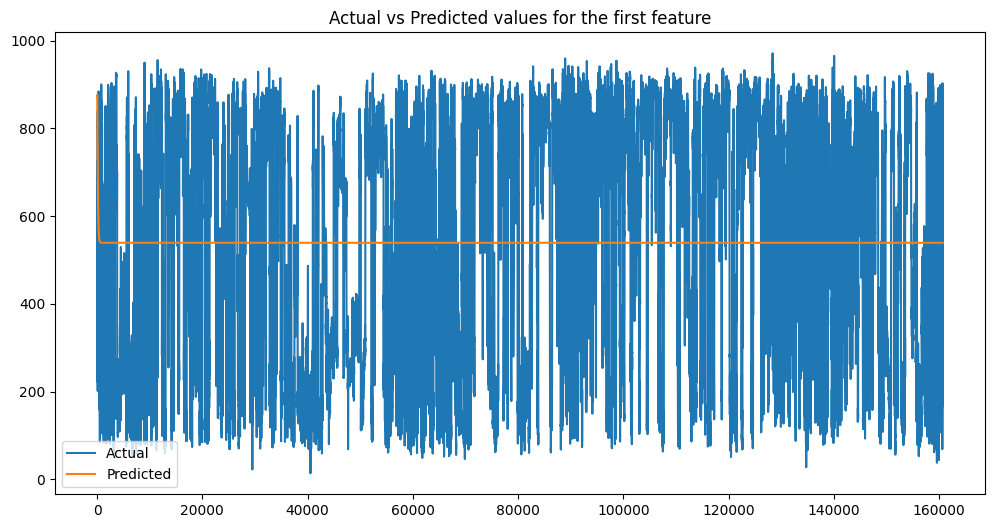

In [ ]:
lag_order = fitted_model.k_ar
predicted_values = fitted_model.forecast(training_keypoints[-lag_order:], steps=len(training_keypoints))

# Plot the actual vs predicted values for the first feature
plt.figure(figsize=(12, 6))
plt.plot(training_keypoints[:, 0], label='Actual')
plt.plot(range(lag_order, lag_order + len(predicted_values)), predicted_values[:, 0], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted values for the first feature')
plt.show()

In [ ]:
!pip install statsmodels numpy matplotlib
import os
import requests
import zipfile
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               160654
Model:                            GLM   Df Residuals:                   160625
Model Family:                Binomial   Df Model:                           28
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -46520.
Date:                Wed, 24 Jul 2024   Deviance:                       93040.
Time:                        08:16:13   Pearson chi2:                 1.61e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01367
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7924      0.041     43.961      0.0

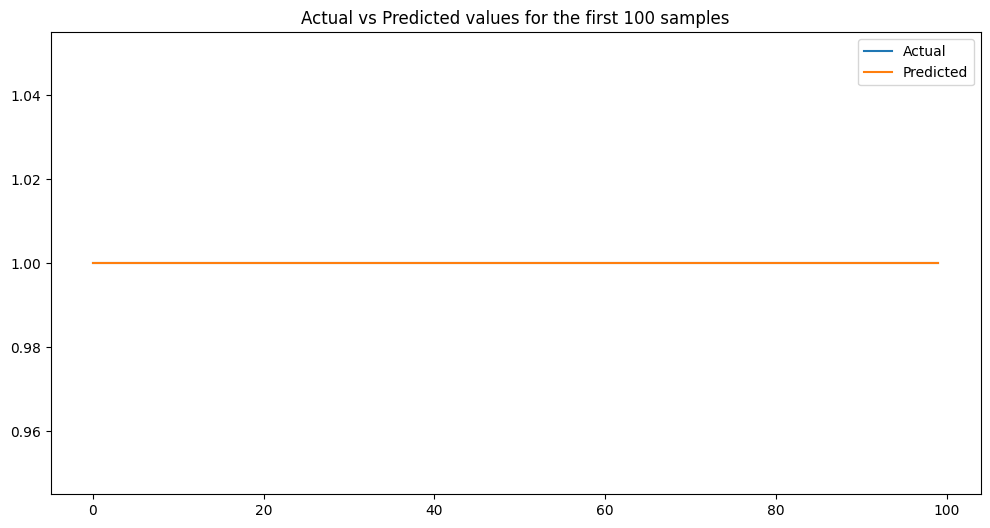

In [ ]:
X_train, y_train = preprocess_data(training_data, vocab)
X_test, y_test = preprocess_data(test_data, vocab)

# Fit the GLM
X_train_const = sm.add_constant(X_train)  # Add intercept term
glm_binom = sm.GLM(y_train, X_train_const, family=sm.families.Binomial())
fitted_glm = glm_binom.fit()

# Print the summary of the GLM model
print(fitted_glm.summary())

# Predict on the test set
X_test_const = sm.add_constant(X_test)  # Add intercept term
predicted_probs = fitted_glm.predict(X_test_const)
predicted_classes = (predicted_probs > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot actual vs predicted values for a subset of the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual')
plt.plot(predicted_classes[:100], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted values for the first 100 samples')
plt.show()